# EcoSort AI Model Training

## Configurations

In [73]:
BATCH_SIZE = 64
LR = 1e-3
LOGGING = True
log_file='training_logs.csv'
RESUME_TRAINING = False
MODEL_PATH=''

In [35]:
import torch
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [ ]:
import csv
with open(log_file, mode='w+', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'])

## Custom Dataset Creation
#### Dataset [link](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)
#### Dividing the dataset into four main classes
- Recyclable
- Non-Recyclable
- Hazardous
- BioDegradable

In [75]:
# imports
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
import torch
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet, EfficientNet_B0_Weights
import csv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

##### Adding Image Transformations

In [43]:
training_transformations = v2.Compose([
  v2.RandomResizedCrop(size=(224, 224), antialias=True),
  v2.RandomHorizontalFlip(p=0.5),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transformations = v2.Compose([
  v2.Resize(size=256, antialias=True),
  v2.CenterCrop(224),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##### Creating Custom Dataset

In [44]:
generator = torch.Generator().manual_seed(7)

dataset = ImageFolder(root='../data', transform=training_transformations)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

print("train size - " + str(train_size))
print("val size - " + str(val_size))
print("test size - " + str(test_size))

train_ds, val_ds, test_ds =  random_split(dataset, [train_size, val_size, test_size])

train size - 10860
val size - 2327
test size - 2328


- Creating the Dataloader

In [45]:
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


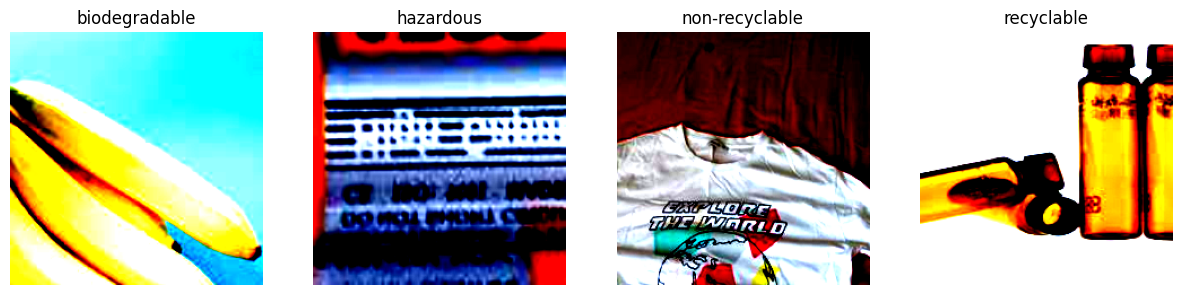

In [76]:
idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}

seen_classes = set()
samples = []

for img, label in dataset:
  if label not in seen_classes:
    samples.append((img, label))
    seen_classes.add(label)
  if len(seen_classes) == len(dataset.classes):
    break


fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
for ax, (img, label) in zip(axes, samples):
  ax.imshow(img.permute(1, 2, 0))
  ax.set_title(idx_to_class[label])
  ax.axis("off")
plt.show()


## Setting up the Model for fine tuning
- Using the EfficientNetB0 model for this project [link](https://arxiv.org/abs/1905.11946)

In [ ]:
if not RESUME_TRAINING:
  model = efficientnet.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1, progress=True)
else:
  model = efficientnet.efficientnet_b0(weights=None)
  model.load_state_dict(torch.load(MODEL_PATH))

- Updating the final linear layer so that model learns to classify images into required four categories

In [49]:
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=4)

## Training Loop

In [50]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [51]:
def train_epoch(model, loss_fn, optimizer, train_dataloader, device):
  model.train()
  model.to(device)
  total_loss = 0
  for inputs, labels in train_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    preds = model(inputs)
    
    optimizer.zero_grad()
    
    loss = loss_fn(preds, labels)
    loss.backward()
    
    optimizer.step()
    
    total_loss += loss.item()

  return total_loss/len(train_dataloader)

In [64]:
def val_epoch(model, loss_fn, val_dataloader, device):
  with torch.no_grad():
    model.eval()
    model.to(device)
    total_loss = 0
    all_preds = []
    all_labels = []
    for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      preds = model(inputs)      
      
      loss = loss_fn(preds, labels)

      preds = preds.argmax(dim=1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
            
      total_loss += loss.item()

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')


    return total_loss/len(val_dataloader), acc, precision, recall, f1

In [69]:
def log_metrics(log_file, epoch, train_loss, val_loss, val_acc, val_precision, val_recall, val_f1):
  with open(log_file, mode='w+', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([epoch, train_loss, val_loss, val_acc, val_precision, val_recall, val_f1])

In [ ]:
epochs_start = 0
epochs_end = 1

In [ ]:
for epoch in range(epochs_start, epochs_end):
  train_loss = train_epoch(model, loss_fn, optimizer, train_dataloader, device)
  val_loss, acc, precision, recall, f1 = val_epoch(model, loss_fn, val_dataloader, device)


  if LOGGING:
    log_metrics(log_file, epoch+1, train_loss, val_loss, acc, precision, recall, f1)
  
  if (epoch+1)%5 == 0:
    torch.save(model, f"ecosortAI-{epoch+1}")

  print(f"Epoch::{epoch+1}  ::::::  Train Loss::{train_loss:.4f}  ::::::  Val Loss::{val_loss:.4f}  ::::::  Val Acc::{acc:.4f}  ::::::  Val Precision::{precision:.4f}  ::::::  Val Recall::{recall:.4f}  ::::::  Val F1 Score::{f1:.4f}")

Epoch::1  ::::::  Train Loss::0.2251  ::::::  Val Loss::0.1674  ::::::  Val Acc::0.9411  ::::::  Val Precision::0.9150  ::::::  Val Recall::0.9183  ::::::  Val F1 Score::0.9151
